In [1]:
import os
import  zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# os.makedirs("MosMedData")

In [2]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
!ls

CT-0.zip  CT-23.zip  MosMedData


In [ ]:
# with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
#     z_fp.extractall("./MosMedData/")

# with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
#     z_fp.extractall("./MosMedData/")

In [7]:
import nibabel as nib

from scipy import ndimage

def read_nifti_file(filepath):
  scan = nib.load(filepath)
  scan = scan.get_fdata()
  return scan

def normalize(volume):
  min = -1000
  max = 400
  volume[volume < min] = min
  volume[volume > max] = max
  return volume
  
def resize_volums(img):
  desired_depth = 64
  desired_width = 128
  desired_height = 128

  current_depth = img.shape[-1]
  current_width = img.shape[0]
  current_height = img.shape[1]

  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height
  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height
  
  img = ndimage.rotate(img, 90, reshape=False)
  img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
  return img

def process_scan(path):
  volume = read_nifti_file(path)
  volume = normalize(volume)
  volume = resize_volums(volume)
  return volume

In [8]:
normal_scan_paths = [
                     os.path.join(os.getcwd(), 
                                  "MosMedData/CT-0", x) for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
                       os.path.join(os.getcwd(), 
                                    "MosMedData/CT-23", 
                                    x) for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [9]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [11]:
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print("Number of samples in trai and validation are %d ans %d."
% (x_train.shape[0], x_val.shape[0]))

Number of samples in trai and validation are 140 ans 60.


In [26]:
import random

from scipy import ndimage

@tf.function
def rotate(volume):
  def scipy_rotate(volume):
    angles = [-20, -10, -5, 5, 10, 20]
    angle = random.choice(angles)
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

  augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float64)
  return augmented_volume

def train_preprocessing(volume, label):
  volume = rotate(volume)
  volume = tf.expand_dims(volume, axis=3)
  return volume, label

def validation_preprocessing(volume, label):
  volume = tf.expand_dims(volume, axis=3)
  return volume, label

In [27]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


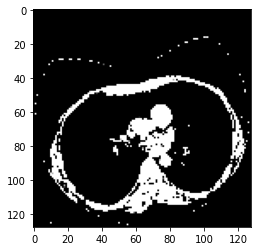

In [28]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

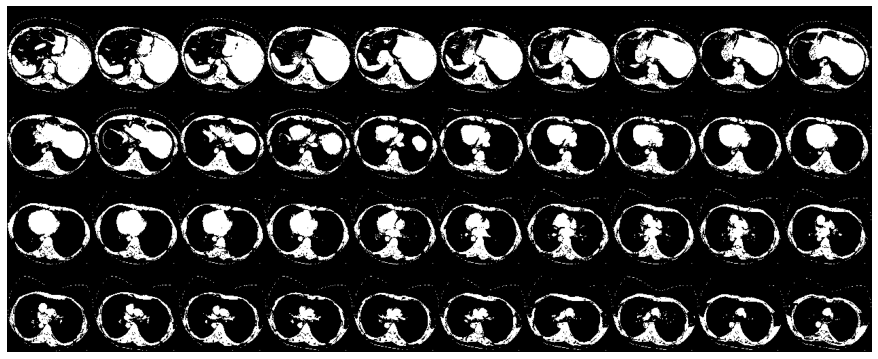

In [34]:
def plot_slices(num_rows, num_columns, width, height, data):
  data = np.rot90(np.array(data))
  data = np.transpose(data)
  data = np.reshape(data, (num_rows, num_columns, width, height))
  rows_data, columns_data = data.shape[0], data.shape[1]
  heights = [slc[0].shape[0] for slc in data]
  widths = [slc.shape[1] for slc in data[0]]
  fig_width = 12.0
  fig_height = fig_width * sum(heights) / sum(widths)
  f, axarr = plt.subplots(
      rows_data,
      columns_data,
      figsize = (fig_width, fig_height),
      gridspec_kw = {"height_ratios": heights},
  )
  for i in range(rows_data):
    for j in range(columns_data):
      axarr[i, j].imshow(data[i][j], cmap="gray")
      axarr[i, j].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

plot_slices(4, 10, 128, 128, image[:, :, :40])